# Feature engineering

https://www.youtube.com/watch?v=nT6UsVgJ0xw

In [22]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

## Get data

In [10]:
data_file_name =  pathlib.Path('..') / '..' / 'download_data_dir' / 'air_quality.csv'

In [11]:
data_file_name.exists()

True

In [12]:
air_df = pd.read_csv(data_file_name, index_col='date_local', parse_dates=True)

In [13]:
air_df.shape

(3562, 1)

## Prepare data

In [26]:
air_df['month'] = air_df.index.month
air_df['time'] = np.arange(len(air_df.index))

Split data into test and train

In [27]:
air_df_train = air_df.loc[:'2015-4'].copy()
air_df_test = air_df.loc['2015-5':].copy()

## Plot

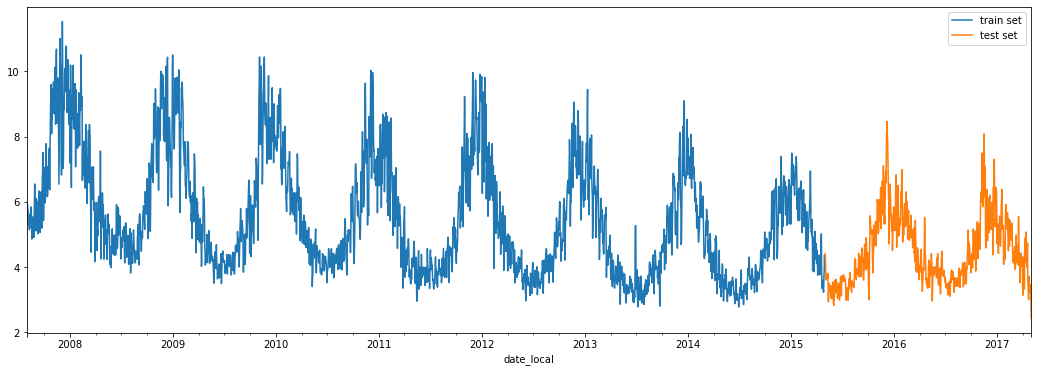

In [28]:
fig, ax = plt.subplots(figsize=(18, 6))
air_df_train[['aqi']].plot(ax=ax)
air_df_test[['aqi']].plot(ax=ax)
plt.legend(['train set', 'test set'])

In [29]:
air_df.head()

,aqi,month,time
date_local,,,
2007-08-01,5.522124,8,0
2007-08-02,5.894895,8,1
2007-08-03,5.928358,8,2
2007-08-04,5.792285,8,3
2007-08-05,5.744807,8,4


In [38]:
X_monthly = air_df_train[['time', 'month']]
y_train = air_df_train['aqi'].values

In [39]:
feature_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first'), ['month'])],
    remainder='passthrough'
)

In [40]:
model_monthly = Pipeline([
    ('preprocess', feature_transformer),
    ('model', LinearRegression())
])

In [43]:
lm_monthly = model_monthly.fit(X_monthly, y_train)

In [44]:
print(f'R^2 is {round(lm_monthly.score(X_monthly, y_train), 3)}')

R^2 is 0.811


In [47]:
air_df['y_pred_monthly'] = lm_monthly.predict(air_df[['time', 'month']])

<AxesSubplot:xlabel='date_local'>

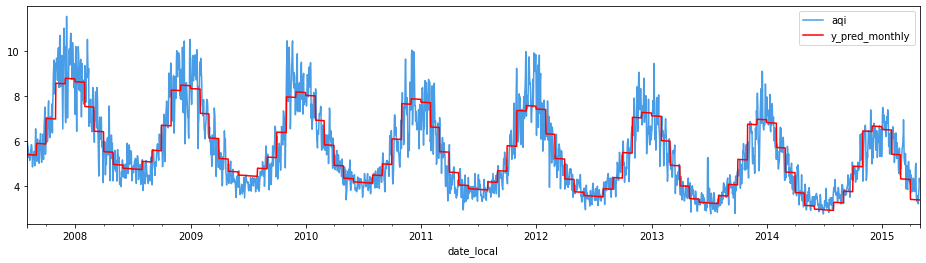

In [48]:
air_df[['aqi', 'y_pred_monthly']].loc[:'2015-4'].plot(
    figsize=(16, 4), color=['#499DE6', 'red'])

In [54]:
average_season_effect = np.dot(
    lm_monthly['model'].coef_[:-1], [1/12] * 11)

In [60]:
def trend_fn(df):
    return lm_monthly['model'].intercept_ + lm_monthly['model'].coef_[-1] * df['time'] + average_season_effect

In [64]:
simple_ets = (
    air_df[['aqi', 'y_pred_monthly', 'time']].loc[:'2015-4'].rename(
        columns={'aqi': 'y_real',
                 'y_pred_monthly': 'y_hat'}).assign(
    residuals=lambda df: df['y_real'] - df['y_hat'],
    trend=trend_fn,
    seasonal = lambda df: df['y_hat'] - df['trend']
))

<AxesSubplot:xlabel='date_local'>

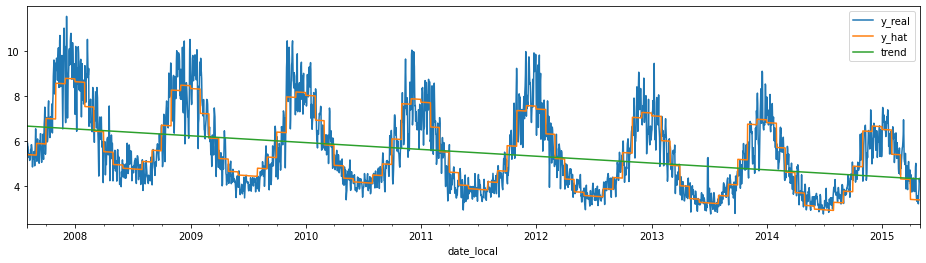

In [65]:
simple_ets[['y_real', 'y_hat', 'trend']].plot(figsize=(16, 4))

<AxesSubplot:xlabel='date_local'>

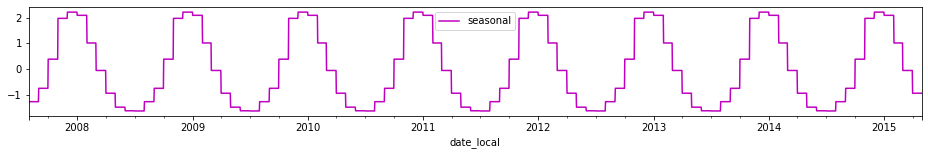

In [67]:
simple_ets[['seasonal']].plot(figsize=(16,2), c='m')

<AxesSubplot:xlabel='date_local'>

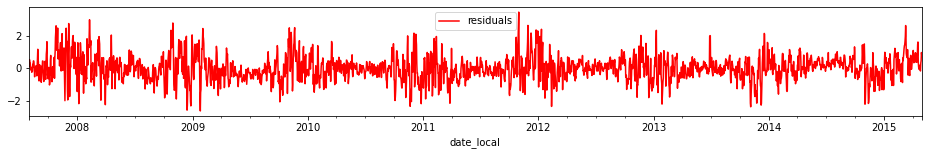

In [68]:
simple_ets[['residuals']].plot(figsize=(16,2), c='r')

In [69]:
simple_ets = (
    simple_ets.assign(
        deseasonalized=lambda df: df['y_real'] - df['seasonal'],
        detrended=lambda df: df['y_real'] - df['trend']))

<AxesSubplot:xlabel='date_local'>

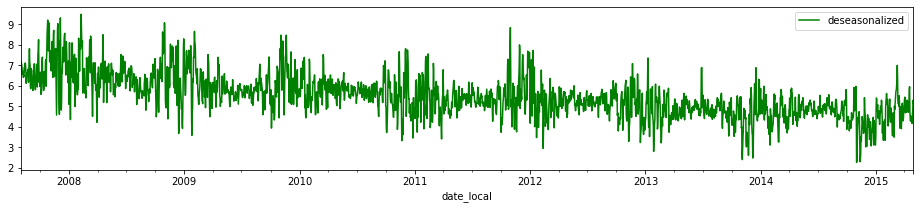

In [70]:
simple_ets[['deseasonalized']].plot(figsize=(16, 3), c='g', label='deseasonalized')

<AxesSubplot:xlabel='date_local'>

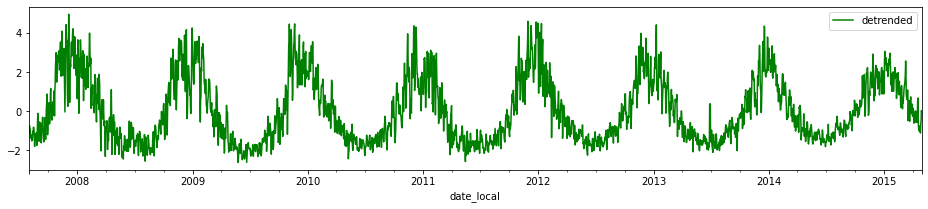

In [71]:
simple_ets[['detrended']].plot(figsize=(16, 3), c='g', label='detrended')